In [1]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from model import Inputs, build_network

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='ticks', font='CMU Serif', rc={'font.size':12, 'mathtext.fontset': 'cm'})

In [2]:
def run_once(deltaP, maxCues=12, seed=0, dt=0.001, legend=False, name="default", **kwargs):
    inputs = Inputs(deltaP=deltaP, maxCues=maxCues, seed=seed)
    inputs.set_AB()
    net = build_network(inputs, seed=seed, **kwargs)
    sim = nengo.Simulator(net, progress_bar=False)
    chosen = False
    cues_sampled = 0
    total_cues = 0
    with sim:
        while total_cues<=2*maxCues:
            sim.run(0.5, progress_bar=False)
            chooseA = np.argwhere(sim.data[net.pAction][:,0] > 0)  # indices of time points when model was choosing A as action output
            chooseB = np.argwhere(sim.data[net.pAction][:,1] > 0)  # indices of time points when model was choosing B as action output
            if not chosen: cues_sampled += 1
            chosen = True if (len(chooseA)>0 or len(chooseB)>0) else False
            total_cues += 1
#             print(f"chosen={chosen}, cues={total_cues}")

    if chosen:  # if the model made a choice before maxCues was reached
        chooseA = np.argwhere(sim.data[net.pAction][:,0] > 0)
        chooseB = np.argwhere(sim.data[net.pAction][:,1] > 0)
        firstA = chooseA[0][0] if len(chooseA)>0 else int(maxCues/dt)  # first time point when model chose A
        firstB = chooseB[0][0] if len(chooseB)>0 else int(maxCues/dt)  # first time point when model chose B
        choice = "A" if firstA < firstB else "B"
    else:  # if the model was forced to choose after sampling maxCues
        valueA = sim.data[net.pAccumulator][-1][0]
        valueB = sim.data[net.pAccumulator][-1][1]
        choice = "A" if valueA > valueB else "B"
    is_correct = True if choice==inputs.correct else False
    
    idealA = np.cumsum(sim.data[net.pInputs][:,0]) * net.m * dt
    idealB = np.cumsum(sim.data[net.pInputs][:,1]) * net.m * dt
    ymin = np.around(np.min(np.concatenate((idealA, idealB))), 1)
    ymax = np.around(np.max(np.concatenate((idealA, idealB))), 1)
    y2a = np.around(np.max(np.abs(sim.data[net.pAccumulator][:,0]-sim.data[net.pAccumulator][:,1])), 1)
    y2b = np.around(np.max(sim.data[net.pGate]), 1)
    y2c = max(y2a, y2b)

    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=((7.08, 2.5)))
    axes[0].plot(sim.trange(), idealA, linestyle="--", color=palette[0])  # label="ideal A",
    axes[0].plot(sim.trange(), idealB, linestyle="--", color=palette[1])  # label="ideal B",
    axes[0].plot(0, 0, linestyle="--", color='k', label="ground truth")
    axes[0].plot(sim.trange(), sim.data[net.pAccumulator][:,0], color=palette[0])  # label="value A", 
    axes[0].plot(sim.trange(), sim.data[net.pAccumulator][:,1], color=palette[1])  # label="value B", 
    axes[0].plot(0, 0, color='k', label='model estimate') 
    axes[0].scatter(0, 0, color=palette[0], label='A') 
    axes[0].scatter(0, 0, color=palette[1], label='B') 
    axes[1].plot(sim.trange(), np.abs(sim.data[net.pAccumulator][:,0]-sim.data[net.pAccumulator][:,1]),
#                  label=r'$|\hat{\mathbf{x}}_0-\hat{\mathbf{x}}_1|$', color=palette[4])
                 label="evidence", color=palette[2])
    axes[1].plot(sim.trange(), sim.data[net.pGate], label='inhibition', color=palette[4])  # 
    axes[1].plot(sim.trange(), sim.data[net.pAction][:,0], label=r"choose A", color=palette[0]) # $\rightarrow$
    axes[1].plot(sim.trange(), sim.data[net.pAction][:,1], label=r"choose B", color=palette[1]) # $\rightarrow$
    axes[1].axvline(cues_sampled*0.5, color='lime' if is_correct else 'red', lw=2)  # , label='decision time'
    axes[0].set(xlabel="Cues Sampled", ylabel=r"$\mathbf{\hat{x}}(t)$", title="Accumulator Value", yticks=((ymin, 0, ymax)),
                xlim=((0, maxCues)), xticks=np.arange(0, maxCues+1, 1), xticklabels=np.arange(0, 2*maxCues+2, 2))
    axes[1].set(xlabel="Cues Sampled", ylabel=None, title="Decision Criteria", yticks=((0, y2c)),
                xlim=((0, maxCues)), xticks=np.arange(0, maxCues+1, 1), xticklabels=np.arange(0, 2*maxCues+2, 2))
    if legend:
        axes[0].legend(loc='upper left', ncol=1)
        axes[1].legend(loc='upper left', ncol=1)
    plt.tight_layout()
    fig.savefig(f"plots/{name}.svg")
    fig.savefig(f"plots/{name}.png", dpi=600)

## Figure 2-3

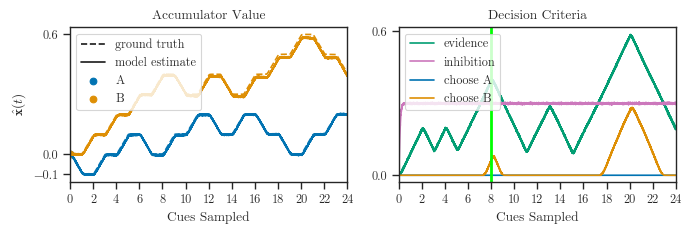

In [3]:
run_once(deltaP=0.1, seed=0, T=0.3, legend=True, name="Fig2")

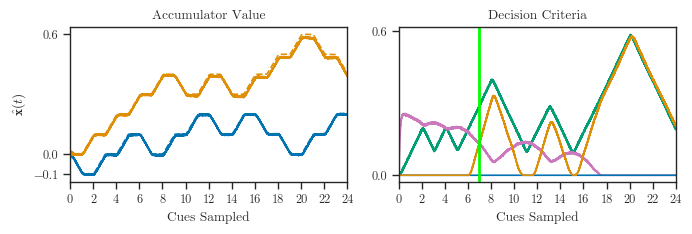

In [4]:
run_once(deltaP=0.1, seed=0, T=0.3, tau=0.02, delta=0.4, name="Fig3")